In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
from time import perf_counter

from tst import Transformer
import os
import pandas as pd
import torch.nn as nn

# from src.dataset import OzeDataset
# from src.utils import compute_loss
# from src.utils import preprocess
# from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

==================================The blocks below are for loading the original data and proprocessing===================================

In [2]:
path = 'E:/S2S data sample/'


us_mask = pd.DataFrame(pd.read_hdf(path + 'us_mask.h5'))
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
# previous lat/lon = 25.25, 279.25
tar_lat = 33.75
tar_lon = 242.25
y_samp = pd.Series()
X_total = []

# !!! 2014-2019

for i in range(2014,2019):
    print('precip.'+str(i)+'.h5')
    name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    name_hgt = 'hgt500.'+str(i)+'.h5'
    name_rhum = 'rhum.sig995.'+str(i)+'.h5'
    name_tmp2m = 'tmp2m.'+str(i)+'.h5'
    fileloc_precip = path + name_precip
    fileloc_sst = path + name_sst
    fileloc_hgt = path + name_hgt
    fileloc_rhum = path + name_rhum
    fileloc_tmp2m = path + name_tmp2m
    precip = pd.DataFrame(pd.read_hdf(fileloc_precip)).reset_index() # precipitation
    precip.columns = ['lat', 'lon', 'start_date', 'precip']
    sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index() # Daily sea surface temperature
    sst.columns = ['lat', 'lon', 'start_date', 'sst']
    hgt = pd.DataFrame(pd.read_hdf(fileloc_hgt)).reset_index() # Daily geopotential height at 10mb and 500mb
    hgt.columns = ['lat', 'lon', 'start_date', 'hgt']
    rhum = pd.DataFrame(pd.read_hdf(fileloc_rhum)).reset_index() # Daily relative humidity near the surface
    rhum.columns = ['lat', 'lon', 'start_date', 'rhum']
    tmp2m = pd.DataFrame(pd.read_hdf(fileloc_tmp2m)).reset_index() # Daily average temperature at 2 meters
    tmp2m.columns = ['lat', 'lon', 'start_date', 'tmp2m']
#     print('original', tmp2m.shape)
    
    precip = pd.merge(precip, us_mask, on=['lat','lon'])
    hgt = pd.merge(hgt, us_mask, on=['lat','lon'])
    rhum = pd.merge(rhum, us_mask, on=['lat','lon'])
    tmp2m = pd.merge(tmp2m, us_mask, on=['lat','lon'])
#     print('after merge', tmp2m.shape)
    
    hgt = np.reshape(hgt[(hgt['lat']==tar_lat) & (hgt['lon']==tar_lon)].hgt.to_numpy(),(-1,1))
    rhum = np.reshape(rhum[(rhum['lat']==tar_lat) & (rhum['lon']==tar_lon)].rhum.to_numpy(),(-1,1))
    tmp2m = np.reshape(tmp2m[(tmp2m['lat']==tar_lat) & (tmp2m['lon']==tar_lon)].tmp2m.to_numpy(),(-1,1))
    precip = precip[(precip['lat']==tar_lat) & (precip['lon']==tar_lon)].precip
#     print('one location', tmp2m.shape)
    
    y_samp = y_samp.append(precip[0:365],ignore_index=True)
    
    if i%4 == 0:
        days = 366
    else:
        days = 365
    temp = sst #sst[(sst['lat']>=24.25) & (sst['lat']<=26.25) & (sst['lon']>=278.25) & (sst['lon']<=280.25)]
#     print(temp.shape)
    sst_samp = temp.sst.reset_index().sst.to_numpy()

    size = int(len(sst_samp)/days)
    sst_samp = np.reshape(sst_samp,(size, days)).transpose() # days as rows, different locations as columns
    sst_samp = sst_samp[0:365,:]
    hgt = hgt[0:365,:]
    rhum = rhum[0:365,:]
    tmp2m = tmp2m[0:365,:]
    all_features = np.concatenate((sst_samp,hgt,rhum,tmp2m),axis=1)
#     print('all_features', all_features.shape)
    X_total.append(all_features)
    
X_size = X_total[0].shape[1]
X_samp = np.zeros((1,X_size)) #  For concatenating all data
# print(X_samp.shape)
for i in range(len(X_total)):
    X_samp = np.concatenate((X_samp,X_total[i]),axis = 0)
X_samp = X_samp[1:]
# print(X_samp.shape)

<ipython-input-2-e1be3a9cbbe2>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.2014.h5
precip.2015.h5
precip.2016.h5
precip.2017.h5
precip.2018.h5


In [3]:
# This is for backing up the original data to avoid re-loading
X_copy = X_samp.copy()
y_copy = y_samp.copy()


In [4]:
X_samp

array([[-1.25500000e+00, -1.10000002e+00, -9.02499974e-01, ...,
         5.81058740e+03,  4.98125000e+01,  9.58892155e+00],
       [-1.28250003e+00, -1.13499999e+00, -9.35000002e-01, ...,
         5.79985010e+03,  4.05000000e+01,  1.21086349e+01],
       [-1.31499994e+00, -1.16999996e+00, -9.62499976e-01, ...,
         5.77551270e+03,  4.29624977e+01,  9.57599449e+00],
       ...,
       [-1.31749988e+00, -1.25500000e+00, -1.17499995e+00, ...,
         5.63052490e+03,  4.61624985e+01,  1.04402647e+01],
       [-1.32249999e+00, -1.25749993e+00, -1.18499994e+00, ...,
         5.72400000e+03,  5.31624985e+01,  1.01192760e+01],
       [-1.30999994e+00, -1.24749994e+00, -1.16750002e+00, ...,
         5.63291260e+03,  6.99124985e+01,  1.20464334e+01]])

In [113]:
X_samp = X_copy.copy()
y_samp = y_copy.copy()
target = 'precip'

y_samp = X_copy[:,X_copy.shape[1]-1].copy()
X_samp[:,X_copy.shape[1]-1] = y_copy.copy()
target = 'tmp2m'

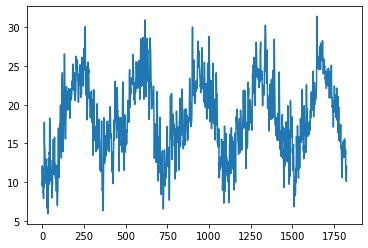

In [114]:
plt.plot(y_samp)

Smoothing

In [115]:
avg_window = 14
y_movavg = []
X_movavg = []
for i in range(y_samp.shape[0]-avg_window):
    y_avg = np.mean(y_samp[i:i+avg_window])
    y_movavg.append(y_avg)
    X_avg = np.mean(X_samp[i:i+avg_window],axis=0)
    X_movavg.append(X_avg)
y_movavg = np.array(y_movavg)
X_movavg = np.array(X_movavg)
y_samp = y_movavg
X_samp = X_movavg

In [116]:
X_samp.shape

(1811, 169730)

In [117]:
X_samp = X_samp[:,-3:]
X_samp.shape

(1811, 3)

In [118]:
X = X_samp.copy()
y = y_samp.copy()

In [119]:
train_test_split = 0.8
test_size = int((1-train_test_split)*y_samp.shape[0])
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

In [120]:
y_train = np.reshape(y_train,(-1,1))  #  Matching dimension for concatenating X and y
y_test = np.reshape(y_test,(-1,1)) 
# train_data_array = np.concatenate((X_train,y_train),axis=1)
# train_data = torch.FloatTensor(train_data_array)
# y_train = torch.FloatTensor(y_train)

(min, max) normalizing for transformer

In [121]:
# use for TRANSFORMER!
M = np.max(y_train)
m = np.min(y_train)
y_train = (y_train -m)/(M - m)

if X.shape[1]>3:   
    X_train_max_0_last3 = np.max(X_train[:,0:-3])
    X_train_min_0_last3 = np.min(X_train[:,0:-3])
    X_train[:,0:-3] = (X_train[:,0:-3] - np.min(X_train[:,0:-3]))/ (np.max(X_train[:,0:-3]) - np.min(X_train[:,0:-3]))

X_train_max_last3 = np.max(X_train[:,-3])
X_train_min_last3 = np.min(X_train[:,-3])
X_train[:,-3] = (X_train[:,-3] - np.min(X_train[:,-3]))/(np.max(X_train[:,-3]) - np.min(X_train[:,-3]))

X_train_max_last2 = np.max(X_train[:,-2])
X_train_min_last2 = np.min(X_train[:,-2])
X_train[:,-2] = (X_train[:,-2] - np.min(X_train[:,-2]))/(np.max(X_train[:,-2]) - np.min(X_train[:,-2]))

X_train_max_last1 = np.max(X_train[:,-1])
X_train_min_last1 = np.min(X_train[:,-1])
X_train[:,-1] = (X_train[:,-1] - np.min(X_train[:,-1]))/(np.max(X_train[:,-1]) - np.min(X_train[:,-1]))

# X = X_samp.copy()
# y = y_samp.copy()

In [122]:
y_test = (y_test -m)/(M - m)

In [123]:
if X.shape[1]>3: 
    X_test[:,0:-3] = (X_test[:,0:-3] - X_train_min_0_last3)/ (X_train_max_0_last3 - X_train_min_0_last3)
X_test[:,-3] = (X_test[:,-3] - X_train_min_last3)/(X_train_max_last3 - X_train_min_last3)
X_test[:,-2] = (X_test[:,-2] - X_train_min_last2)/ (X_train_max_last2 - X_train_min_last2)
X_test[:,-1] = (X_test[:,-1] - X_train_min_last1)/(X_train_max_last1 - X_train_min_last1)

In [124]:
print(y_test.max(), y_test.min())
print(X_test.max(), X_test.min())

1.0228558405328503 0.03795572274244479
1.0257389992279087 -0.005984397162108994


Pre-training, Use after normalization

In [125]:
train_data_array = np.concatenate((X_train,y_train),axis=1)

PCA

In [17]:
from sklearn.decomposition import PCA

In [18]:
sst_data_train = train_data_array[:, 0:169727]
sst_data_test = X_test[:, 0:169727]

In [19]:
sst_data_train.shape

(1450, 169727)

In [20]:
num_pc = 1
pca = PCA(num_pc)
sst_data_train_500 = pca.fit_transform(sst_data_train)

In [21]:
sst_data_train_500.shape

(1450, 1)

In [22]:
sst_data_test_500 = pca.transform(sst_data_test)

In [23]:
sst_data_test_500.shape

(362, 1)

In [24]:
train_data_array[:, -4:].shape

(1450, 4)

In [25]:
a = [1,2, 3, 4, 5]
a = np.array(a)
a[-2:]

array([4, 5])

In [26]:
# create new X and Y with pca features 

train_data_array_new = np.concatenate((sst_data_train_500, train_data_array[:, -4:]), axis=1)

In [27]:
train_data_array_new.shape

(1450, 5)

In [28]:
test_data_new = np.concatenate((sst_data_test_500, X_test[:, -3:]), axis=1)
test_data_new.shape

(362, 4)

In [29]:
y_train[:3]

array([[0.35364852],
       [0.31931425],
       [0.25282873]])

In [30]:
train_data_array_new[:3, -1]

array([0.35364852, 0.31931425, 0.25282873])

In [126]:
if X.shape[1]<=3:
    train_data_array_new = train_data_array[:,-1].reshape((-1,1))
    test_data_new = X_test

In [127]:
train_data_array_new.shape

(1449, 1)

In [128]:
train_data = torch.FloatTensor(train_data_array_new)
y_train = torch.FloatTensor(y_train)

In [129]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data = train_data.to(device)
y_train = y_train.to(device)

In [130]:
device

device(type='cuda')

Sequentialize the whole time series using moving windows --- create (X, y) samples

In [131]:
def create_sequence(input_data, train_window, pred_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    print('feature_size', feature_size)
    for i in range(L - train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window+pred_window-1,feature_size-1] # get y_t+14
#         train_label = input_data[i + train_window + pred_window]
        seq.append((train_seq ,train_label))
        
    print('train_seq, train_label', train_seq.shape, train_label.shape)
    return seq

In [132]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data, train_window, pred_window)

feature_size 1
train_seq, train_label torch.Size([90, 1]) torch.Size([])


In [133]:
y_normed = np.concatenate((y_train.cpu(), y_test))

In [134]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        
        self.seq_data = seq_data
        self.x = []
        self.y = []
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [135]:
dataset_train = SeqDataset(train_seq)
dataloader_train = DataLoader(dataset_train,
                              batch_size=32,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

Initializing the transformer: Note that the inputs $X$ are sub-sequences of a multivariate time series, so d_input is the number of features in $X$, and the seq_length defined in the transformer is the length of the sub-sequences $X$, Note that here we are using train_window, which is used to create sub-sequences of length 90 from the original time series. (Please check the create_sequence function above).

In our prediction task, the target variable is just a scalar so d_output $= 1$. Those are parameters that need to be changed for adapting this network to a different dataset. The other parameters are all hyperparameters.

In [136]:
d_input = train_data_array_new.shape[1] # From dataset
d_output = 1 # From dataset

attention_size = 8
LR = 1e-4 #1e-3
d_model = 64
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
# pe = 'original' # Positional encoding
chunk_mode = None
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=2, seq_length=train_window).to(device)
# net = nn.Sequential(Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
#                   dropout=dropout, chunk_mode=chunk_mode, pe=pe),
#                     nn.Flatten(),
#                     nn.Linear(30, 1),
#                    ).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss() #OZELoss(alpha=0.3)

[Epoch  98/100]: 100%|██████████| 1331/1331 [00:01<00:00, 757.18it/s, loss=0.0114]


[Epoch 100/100]: 100%|██████████| 1331/1331 [00:01<00:00, 731.85it/s, loss=0.0112]


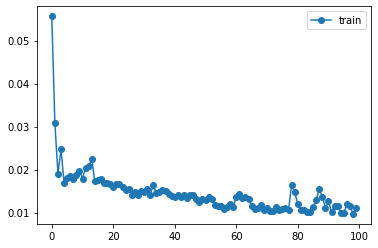

In [137]:
EPOCHS = 100
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
#         hist_loss_val[idx_epoch] = val_loss

#         if val_loss < val_loss_best:
#             val_loss_best = val_loss
#             torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

In [138]:
test_data = np.concatenate((test_data_new, y_test),axis=1)
test_data = y_test
train_test_total = np.concatenate((train_data_array_new, test_data))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

100%|██████████| 1721/1721 [00:22<00:00, 76.63it/s]


r-sq on train: 0.8088868658940297
r-sq on test: 0.8373767435090755
cosine_similarity on train: [[0.98603197]]
cosine_similarity on test: [[0.98728071]]


NameError: name 'num_pc' is not defined

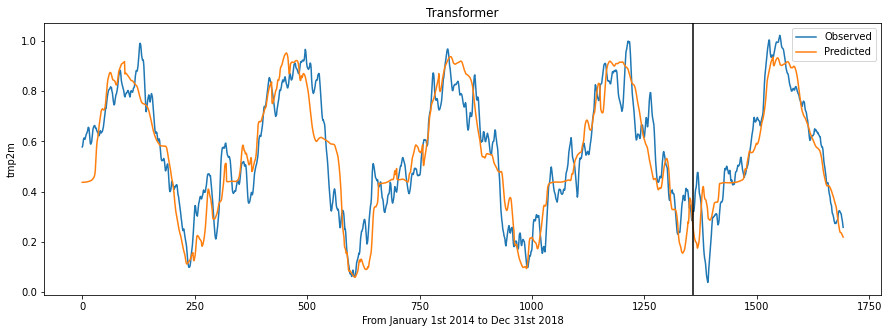

In [139]:
y_train = y_train.cpu()

print('r-sq on train:', r2_score(y_normed[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_normed[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_normed[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_normed[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_normed[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');
testname = 'results/Transformer_PCA_'+str(num_pc)+'.png'
plt.savefig(testname)